In [2]:
import torch
from torch import nn

# Hereda de nn.Module
class MyLinear(nn.Module):
  # Definición del modelo
  def __init__(self, in_features, out_features):
    super().__init__()
    self.weight = nn.Parameter(torch.randn(in_features, out_features))
    self.bias = nn.Parameter(torch.randn(out_features))
  # Definición de la operación forward
  def forward(self, input):
    return (input @ self.weight) + self.bias
  
m = MyLinear(4, 3)
sample_input = torch.randn(4)
m(sample_input)  

tensor([0.1669, 0.6345, 4.2212], grad_fn=<AddBackward0>)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Definición de la arquitectura del modelo
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = nn.functional.log_softmax(x, dim=1)
        return output

# Load the MNIST Dataset
train_dataset = datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

test_dataset = datasets.MNIST('./data', train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the network and optimizer
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# Define a function to train the model
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.functional.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

# Define a function to test the model
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.functional.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Train and test the model
for epoch in range(1, 11):
    train(epoch)
    test()

/home/diegoandrade/.local/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307972
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.614601
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.545359
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.280141
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.473983
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.522550
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.177747
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.486807
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.209534
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.353559

Test set: Average loss: 0.1437, Accuracy: 9561/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.323789
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.397856
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.349941
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.145273
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.267328
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.217238
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.266196
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.200315
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.151066
T

In [5]:
!pip install torchsummary
from torchsummary import summary
#Visualizamos la arquitectura de la red
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Defaulting to user installation because normal site-packages is not writeable
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
         Dropout2d-3           [-1, 64, 12, 12]               0
            Linear-4                  [-1, 128]       1,179,776
         Dropout2d-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.52
Params size (MB): 4.58
Estimated Total Size (MB): 5.10
----------------------------------------------------------------


/home/diegoandrade/.local/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Defaulting to user installation because normal site-packages is not writeable


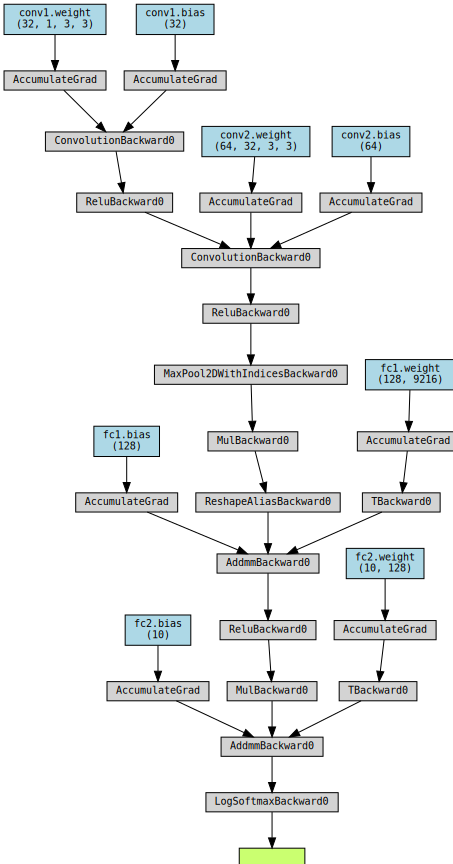

In [4]:
!pip install torchviz
import torchviz
from torch.autograd import Variable

model = Net().to(device)
x = Variable(torch.randn(1, 1, 28, 28)).to(device)
torchviz.make_dot(model(x), params=dict(model.named_parameters()))

Defaulting to user installation because normal site-packages is not writeable


/home/diegoandrade/.local/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


AttributeError: module 'torch.onnx' has no attribute '_optimize_trace'